<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2024-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales y convolucionales con Keras - Clasificación de imágenes y Superresolución

A lo largo de esta práctica implementaremos varios modelos de redes neuronales, empleando Keras sobre la base de datos Imagenette (versión 320px)​. En concreto, abordaremos las siguientes tareas:
1. Descarga, análisis y pre-procesado de los datos (1.5 pts)
2. Red Neuronal Artificial (ANN) completamente conectada (1.5 pts)
3. Pequeña Red Neuronal Convolucional (CNN) (2 pts)
4. Aumentación de datos (1 pt)
5. Superresolución de imágenes con CNNs (1.5 pts)
6. Inferencia, métricas y visualización de resultados (1 pt)
7. Modelo pre-entrenado en superresolución (1 pt)
8. Comparativa y conclusiones (0.5 pts)

<u>Consideraciones generales</u>:

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.
- Si se hace uso de cualquier **IA generativa** en la resolución de la PEC esta **debe referenciarse** en aquellos apartados donde se haya utilizado, como cualquier otra fuente.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML en Jupyter Notebook desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Contexto y carga de librerías
A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de la base de datos [Imagenette](https://github.com/fastai/imagenette).

La base de datos Imagenette es un subconjunto de 10 clases fácilmente clasificables de [Imagenet](https://www.image-net.org/), un proyecto que ha sido fundamental para avanzar en la investigación sobre visión artificial y aprendizaje profundo. Imagenette contiene alrededor de 13.000 imágenes de diferentes tamaños pertenecientes a 10 categorías (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute), cada una en una carpeta distinta.

Concretamente en esta PEC utilizaremos una versión (Imagenette2-320) que ha sido reescalada pero manteniendo el aspect ratio de cada imagen (se han ajustado de forma que la dimensión menor de cada imagen es 320 píxeles). Esto atenuará la carga computacional de los algoritmos al usar bases de datos de imágenes pero manteniendo la suficiente calidad necesaria para nuestros experimentos. Los datos vienen separados en 2 conjuntos, entrenamiento y validación.

**Nota: Debido al uso de imágenes como datos en esta práctica, los entrenamientos de cada ejercicio se pueden demorar desde unos minutos a más de media hora utilizando GPU (los tiempos con CPU son sensiblemente más largos). Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Se aconseja la lectura detallada de la documentación de ambos modelos para llevar a cabo la realización de la práctica.

Empezamos instalando y cargando las librerías más relevantes:

In [41]:
# Instalamos la última versión de Tensorflow (con CUDA)
%pip install tensorflow[and-cuda]

^C
Note: you may need to restart the kernel to use updated packages.


In [42]:
# Importamos Tensorflow
import tensorflow as tf
print("TensorFlow version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Keras version is 3.5.0
from tensorflow import keras
print("Keras version   : ", keras.__version__)

TensorFlow version   :  2.17.1
GPU is available
Keras version   :  3.5.0


In [43]:
# Importamos los elementos de Keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (Input, Dense, Dropout, Flatten, Conv2D, Conv2DTranspose,
                          MaxPooling2D, UpSampling2D, Rescaling, Resizing,
                          RandomFlip, RandomRotation)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [44]:
# Importamos algunas librerías que necesitaremos para la PEC
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para crear nuestra base de datos tenemos que descargar el archivo de imágenes desde el siguiente [enlace](https://drive.google.com/file/d/16kqYxjXK0xDDYQ4xF3PBgsa0NG3gwT4L/view?usp=sharing) (es un archivo .zip que ocupa aproximadamente 340 MB).

**NOTA: para poder descargar el archivo de imágenes tenéis que iniciar sesión con el usuario y contraseña de la UOC.**

A partir de aquí:

- Si trabajamos en local simplemente tenemos que descomprimir el archivo descargado.

- Si trabajamos desde Kaggle debemos subir el notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, expandir la barra lateral desplegable de la derecha y en el menú 'Input'  clickar el botón 'Upload' y subir el archivo descargado previamente. Después hay que darle un nombre a la base de datos y cuando se cargue el fichero ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

En la carpeta <code>/images</code> (si trabajamos en local) o <code>/kaggle/input/nombre-base-de-datos/images</code> (si trabajamos desde Kaggle) encontramos 2 carpetas:
- En la carpeta <code>/train/</code> se encuentra el total de las imágenes de entrenamiento separadas por clases (cada clase en una carpeta distinta).
- En la carpeta <code>/val/</code> se encuentra el total de las imágenes de validación separadas por clases (cada clase en una carpeta distinta).

Como podemos observar, tenemos imágenes para realizar el entrenamiento y la validación de los modelos pero no tenemos un conjunto de prueba, lo crearemos durante en este primer apartado.

Comencemos obteniendo los datos y analizando su estructura y características.
### 1.1. Análisis de los archivos de imágenes

En primer lugar, inspeccionaremos la organización de los datos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 1.1 [0.5 pts]:</strong> A partir de la estructura de carpetas indicada, y para cada conjunto de datos (<code>train</code> y <code>val</code>):
    <ul>
        <li>Extrae los nombres de las 10 clases en cada conjunto y comprueba que son iguales.</li> <li>Calcula el número total de imágenes en cada conjunto.</li>
        <li>Obtén cuántas instancias hay en total para cada clase y representa la distribución en un diagrama de barras.</li>
        </ul>
Contesta además las siguientes preguntas:
    <ul>
        <li>¿Qué porcentaje del total de imágenes corresponde a cada conjunto (train/val)?</li>
        <li>Según los diagramas de barras, ¿podemos afirmar que la distribución por clases es similar en ambos conjuntos?</li>
        <li>En cuanto al número de imágenes por clase, ¿están las clases balanceadas o hay desequilibrios notables?</li>
    </ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

In [45]:
import os
from pathlib import Path

# Directorios (ajustar la ruta según ubicación de los datos)
train_path = '/kaggle/input/dataset-pec1/images/train'
val_path = '/kaggle/input/dataset-pec1/images/val'

In [46]:
# Listar clases en cada conjunto
clases_train = os.listdir(train_path)
clases_val = os.listdir(val_path)
print(f"Clases train: {clases_train}")
print(f"Clases val: {clases_val}")

Clases train: ['golf_ball', 'church', 'chain_saw', 'cassette_player', 'gas_pump', 'French_horn', 'English_springer', 'parachute', 'tench', 'garbage_truck']
Clases val: ['golf_ball', 'church', 'chain_saw', 'cassette_player', 'gas_pump', 'French_horn', 'English_springer', 'parachute', 'tench', 'garbage_truck']


In [47]:
# Contar total de imágenes por conjunto y por clase

# Imprimir número de imágenes por clase en train
lista_train = [(clase,len(os.listdir(Path(train_path)/clase))) for clase in clases_train]
total_train = sum([elem[1] for elem in lista_train])

print(f"Total de imágenes train: {total_train}")
print(f'Número de imágenes por clase en train:\n{lista_train}')

# Imprimir número de imágenes por clase en val
lista_val = [(clase,len(os.listdir(Path(val_path)/clase))) for clase in clases_val]
total_val = sum([elem[1] for elem in lista_val])

print(f"\nTotal de imágenes val: {total_val}")
print(f'Número de imágenes por clase en val:\n{lista_val}')

# FUENTES:
# https://stackoverflow.com/questions/48190959/how-do-i-append-a-string-to-a-path
# https://www.geeksforgeeks.org/python-os-listdir-method/

Total de imágenes train: 9469
Número de imágenes por clase en train:
[('golf_ball', 951), ('church', 941), ('chain_saw', 858), ('cassette_player', 993), ('gas_pump', 931), ('French_horn', 956), ('English_springer', 955), ('parachute', 960), ('tench', 963), ('garbage_truck', 961)]

Total de imágenes val: 3925
Número de imágenes por clase en val:
[('golf_ball', 399), ('church', 409), ('chain_saw', 386), ('cassette_player', 357), ('gas_pump', 419), ('French_horn', 394), ('English_springer', 395), ('parachute', 390), ('tench', 387), ('garbage_truck', 389)]


In [48]:
# Verificar que ambas listas de clases son iguales
clases_train.sort()
clases_val.sort()
if clases_train == clases_val:
  print("Las listas de clases son iguales.")
else:
  print("Las listas de clases son diferentes.")

Las listas de clases son iguales.


<Axes: title={'center': 'Val'}, xlabel='Clase'>

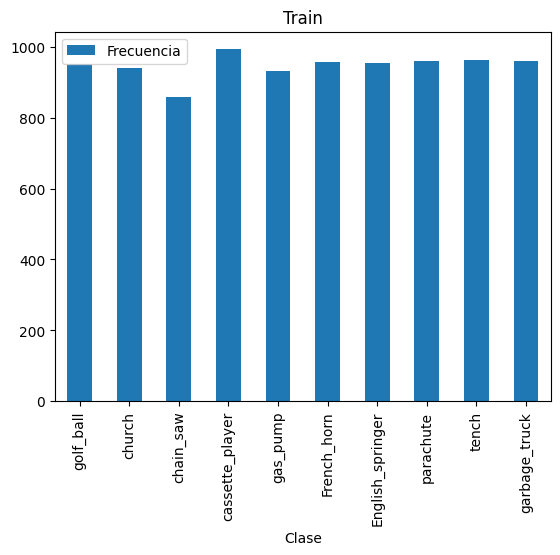

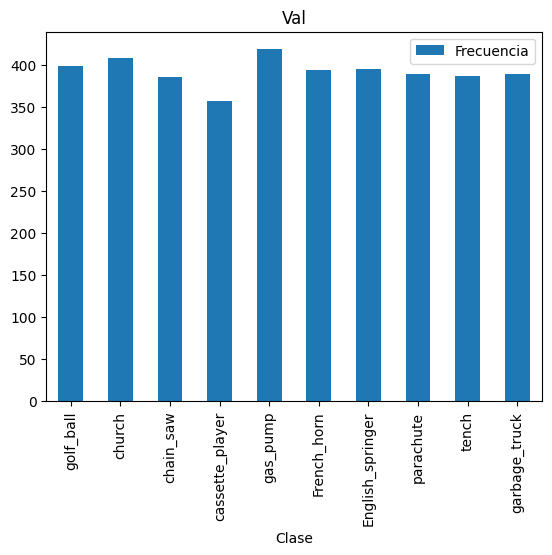

In [49]:
import pandas as pd
# Representación gráfica de la distribución de clases
df = pd.DataFrame(lista_train, columns=['Clase','Frecuencia'])
df.plot(kind='bar', x='Clase', title='Train')

df = pd.DataFrame(lista_val, columns=['Clase','Frecuencia'])
df.plot(kind='bar', x='Clase', title='Val')

# FUENTES:
# https://stackoverflow.com/questions/45080698/make-frequency-histogram-from-list-with-tuple-elements

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
        <ul>
        <li><strong>¿Qué porcentaje del total de imágenes corresponde a cada conjunto (train/val)?</strong>  train = 70,7% / val = 29,3%</li>
        <li><strong>Según los diagramas de barras, ¿podemos afirmar que la distribución por clases es similar en ambos conjuntos?</strong>  Si</li>
        <li><strong>En cuanto al número de imágenes por clase, ¿están las clases balanceadas o hay desequilibrios notables?</strong> En los gráficos no se ven desequilibrios notables, las clases están balanceadas.</li>
    </ul>     
<br><br>
</div>

### 1.2. Visualización de las imágenes.

Ahora examinaremos el formato de las imágenes para entender su tamaño y rango de valores. Visualizaremos algunas imágenes de ejemplo de cada clase.

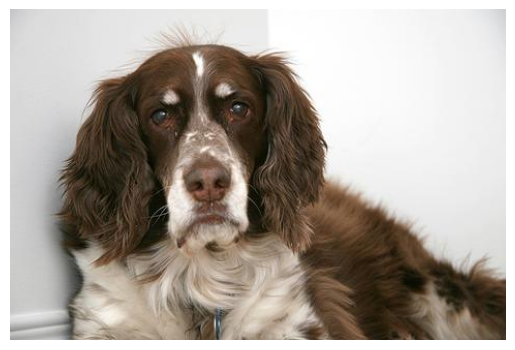

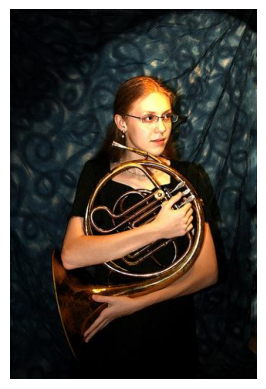

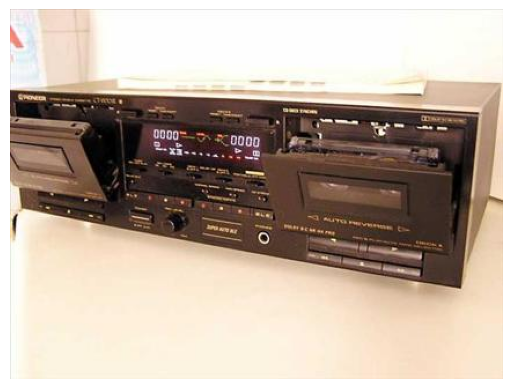

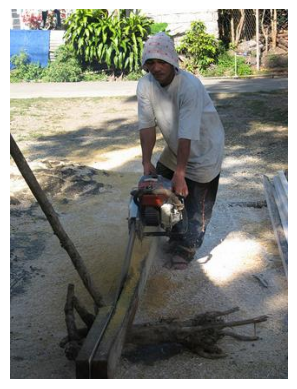

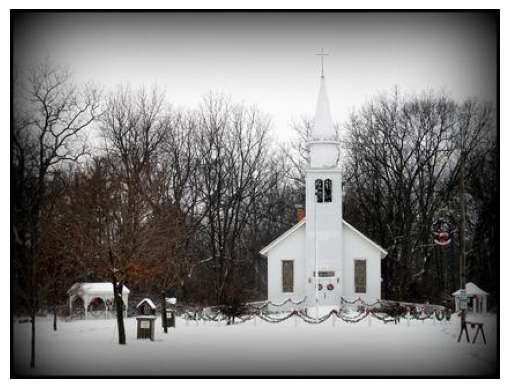

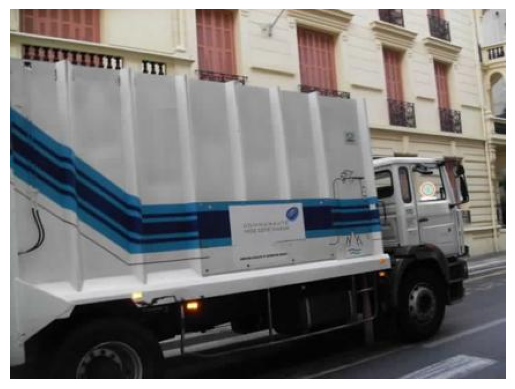

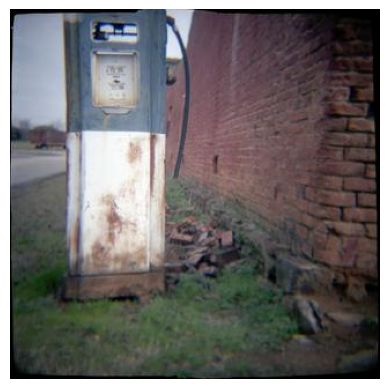

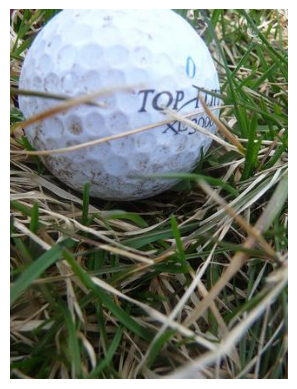

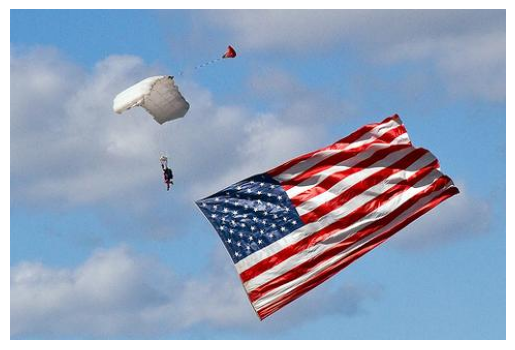

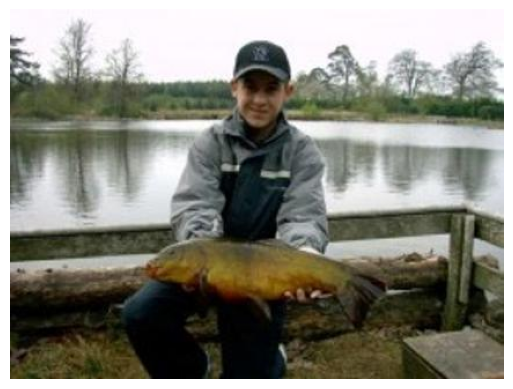

[[255, 0], [255, 0], [255, 0], [255, 0], [255, 0], [255, 0], [255, 0], [255, 0], [255, 0], [255, 0]]


In [50]:
import random
from PIL import Image

random.seed(42)

def get_img_path(folder_path):
  images = list(Path(folder_path).iterdir())
  random_image = random.choice(images)
  return random_image

dyn_range = []
for clase in clases_train:
   img_train_path = get_img_path(Path(train_path)/clase)
   #print(img_train_path)
   image = Image.open(img_train_path)
   #print(np.max(image),np.min(image))
   dyn_range.append([np.max(image),np.min(image)])
   plt.imshow(image)
   plt.axis('off')
   plt.show()

print(dyn_range)

# FUENTES:
# https://www.geeksforgeeks.org/show-random-picture-from-a-folder-in-python/
# https://medium.com/@ingaleashay/loading-and-displaying-images-in-google-colab-a-guide-with-opencv-pil-and-matplotlib-d13bf5b8fe6b

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 1.2 [0.5 pts]:</strong> Muestra a modo de ejemplo una imagen por cada categoría del conjunto de entrenamiento. Luego, responde:
    <ul>
        <li>¿Tienen todas las imágenes las mismas dimensiones (alto × ancho)?</li>
        <li>¿Cuál es el rango dinámico de pixel (valor mínimo y máximo) en las imágenes?</li>
        <li>¿Son adecuados estos valores para el entrenamiento de una red neuronal?</li>
        <li>¿Qué acciones de pre-procesado serían necesarias en relación a lo anterior?</li>
    </ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
        <ul>
        <li><strong>Tamaño</strong>: No, hay diferentes dimensiones.</li>
        <li><strong>Rango dinámico</strong>: [255, 0].</li>
        <li><strong>Adecuación para la red</strong>: Debido a la direrencia de dimensiones y el rango dinámico, sería necesario preprocesar las imágenes.</li>
        <li><strong>Acciones necesarias</strong>: <br>- Redimensionar todas las imágenes para que tengan el mismo tamaño (se podría rellenar las pequeñas usando padding o recortarlas).<br />
        - Normalizar el rango dinámico.</li>
    </ul>
</div>

### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow

A continuación, prepararemos los datos para el entrenamiento con Keras. Usaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> de TensorFlow/Keras, que permite crear lotes de datos etiquetados a partir de directorios de imágenes organizados por clase.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

Esta función nos facilitará generar conjuntos de entrenamiento, validación y prueba a partir de las carpetas analizadas. Las imágenes serán redimensionadas a un tamaño fijo y organizadas en lotes (batch).

**Especificaciones**: Vamos a convertir las imágenes a tamaño 160×160 píxeles y agruparlas en lotes de 64. Mantendremos el rango dinámico original en esta etapa, ya que más adelante aplicaremos una capa de reescalado para normalizarlas (al rango 0-1). También separaremos parte de los datos de test a partir de los de validación.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 1.3 [0.5 pts]:</strong> Utiliza la función <code>tf.keras.utils.image_dataset_from_directory()</code> para generar 3 conjuntos de datos a partir de las carpetas <code>/train</code> y <code>/val</code>:
    <ul>
        <li><strong>train_ds</strong>: Conjunto de entrenamiento a partir de <code>train/</code>. Redimensiona las imágenes a 160×160, con <code>batch_size=64</code> i <code>label_mode="categorical"</code> (10 categorías).</li>
        <li><strong>val_ds</strong>: Conjunto de validación a partir del directorio <code>val/</code>, con un <code>validation_split</code> de 0.5 usando <code>subset="validation"</code> en la función y fija un <code>seed</code> para reproducibilidad. De nuevo redimensiona las imágenes a 160×160, con <code>batch_size=64</code> y <code>label_mode="categorical"</code>.</li>
        <li><strong>test_ds</strong>: Conjunto de test a partir del mismo directorio <code>val/</code> usando <code>subset="training"</code> en la función (con el mismo <code>seed</code> para obtener la partición complementaria). Redimensiona también a 160×160 con <code>batch_size=64</code> y usa <code>label_mode="categorical"</code>.</li>
    </ul>
<strong>NOTA</strong>: la asignación de <code>subset="validation"</code> y <code>subset="training"</code> es completamente arbitraria y podría haberse realizado al revés. Lo importante es dividir los datos que se encuentran en la carpeta <code>/val</code> al 50% entre validación y test.
    <br><br>
Comprueba que la base de datos se ha creado correctamente imprimiendo por pantalla los nombres de las clases así como las dimensiones de cada conjunto de datos.

Responde a las siguientes preguntas:
    <ul>
        <li>¿Qué porcentaje aproximado de las imágenes se utiliza en cada uno de los 3 conjuntos?</li>
        <li>¿Qué otros porcentajes se suelen utilizar?</li>
    </ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para contestar cada una de las respuestas).</strong>
</div>

In [51]:
img_height, img_width = 160, 160
batch_size = 64

# Conjunto de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode="categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 42)

# FUENTES:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Found 9469 files belonging to 10 classes.


In [52]:
# Conjunto de validación y test (usamos el directorio de validación de Imagenette como test)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    label_mode="categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    validation_split = 0.5,
    subset = "validation",
    seed = 42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    label_mode="categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    validation_split = 0.5,
    subset = "training",
    seed = 42
)

Found 3925 files belonging to 10 classes.
Using 1962 files for validation.
Found 3925 files belonging to 10 classes.
Using 1963 files for training.


In [53]:
# Comprobación de los resultados
print('Comprobación train_ds:')
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

print('\nComprobación val_ds:')
print(val_ds.class_names)
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

print('\nComprobación test_ds:')
print(test_ds.class_names)
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# FUENTES:
# https://www.tensorflow.org/tutorials/load_data/images?hl=es-419

Comprobación train_ds:
['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']
(64, 160, 160, 3)
(64, 10)

Comprobación val_ds:
['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']
(64, 160, 160, 3)
(64, 10)

Comprobación test_ds:
['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']
(64, 160, 160, 3)
(64, 10)


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
train: 70,7%<br>
val: ~15%<br>
test: ~15%
<br><br>
Es muy común utilizar:<br>
train: 80%<br>
val: 10%<br>
test: 10%<br><br>
Dependiendo del tamaño del dataset también se pueden llegar a usar:<br>
train: 60%<br>
val: 20%<br>
test: 20%<br>
<br><br>
</div>

## 2. Red Neuronal Artificial (ANN) completamente conectada (1.5 pts)

Como primer modelo entrenaremos una red neuronal **completamente conectada** (red densa o <it>Multilayer Perceptron</it>) para **clasificar las imágenes**. Esta servirá como modelo de referencia (baseline). Dado que manejar imágenes de 160×160 píxeles directamente con capas densas resultaría en vectores de entrada muy grandes y por tanto un número de parámetros enorme, aplicaremos primero una reducción de dimensionalidad de las imágenes de entrada. En concreto, reduciremos cada imagen a 32×32 píxeles (usando una capa de redimensionado) antes de aplanarla, lo que simplificará el modelo.

**Arquitectura propuesta**: Utilizaremos el API funcional de Keras (clase Model) para construir la red. Emplearemos las capas Resizing y Rescaling de Keras para preprocesar las imágenes, seguidas de Flatten para aplanar, y varias capas Dense intercaladas con Dropout para el clasificador.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de Keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 2.1 [0.5 pts]:</strong> Implementa un modelo <strong>funcional</strong> de Keras con las siguientes características:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (160,160) a (32,32).</li>
        <li>Una capa de reescalado para que los valores de píxel queden entre 0 y 1.</li>
        <li>Una capa Flatten para convertir la imagen reducida en un vector 1D.</li>
        <li>Una capa densa completamente conectada que tenga un número de neuronas equivalente a dos tercios del tamaño de la capa anterior, activación ReLU.</li>
        <li>Una capa Dropout con probabilidad 0.5.</li>
        <li>Otra capa densa de la mitad del tamaño que la capa densa inmediatamente anterior, activación ReLU.</li>
        <li>Otra capa Dropout con probabilidad 0.5.</li>
        <li>Una capa de salida densa con el tamaño y función de activación adecuados para el problema de  clasificación que se plantea.</li>
    </ul>
<strong>Nota: Visualizar los modelos de todos los ejercicios con la función <code>summary()</code></strong>
<br><br>
Contestar a las siguientes preguntas:
    <ul>
        <li>¿Qué tamaño debería tener la capa de entrada si hubiéramos trabajado con las imágenes de la base de datos directamente de 160x160 píxeles?</li>
        <li>¿Qué reducción se consigue al re-escalar las imágenes a 32x32 píxeles?</li>
        <li>¿Cuántos parámetros tiene el modelo?</li>
    </ul>

<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>
        

In [54]:
# Construcción del modelo ANN completamente conectado (modelo funcional)
from keras import layers,Model,callbacks,optimizers

img_inputs = Input(shape=(160, 160, 3))

# Una capa que reduzca las dimensiones de entrada de (160,160) a (32,32).
resize = layers.Resizing(32,32,crop_to_aspect_ratio=True)
x = resize(img_inputs)

# Una capa de reescalado para que los valores de píxel queden entre 0 y 1.
x = layers.Rescaling(scale=1./255)(x)

# Una capa Flatten para convertir la imagen reducida en un vector 1D.
x = layers.Flatten()(x)

# Una capa densa completamente conectada que tenga un número de neuronas equivalente a dos tercios del tamaño de la capa anterior, activación ReLU.
x = layers.Dense(2048, activation="relu")(x)

# Una capa Dropout con probabilidad 0.5.
x = layers.Dropout(0.5)(x)

# Otra capa densa de la mitad del tamaño que la capa densa inmediatamente anterior, activación ReLU.
x = layers.Dense(1024, activation="relu")(x)

# Otra capa Dropout con probabilidad 0.5.
x = layers.Dropout(0.5)(x)

# Una capa de salida densa con el tamaño y función de activación adecuados para el problema de clasificación que se plantea.
outputs = layers.Dense(10, activation="softmax")(x)

model = Model(inputs=img_inputs, outputs=outputs, name="ANN_model")
model.summary()

# FUENTES:
# https://keras.io/guides/functional_api/
# https://keras.io/api/layers/

Model: "ANN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2048)                │       6,293,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,401,930 (32.05 MB)

 Trainable params: 8,401,930 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
1. 160*160*3 = 76.800.<br>
2. 3.072/76.800 = 0.04. Se reduce un 96%.<br>
3. 8.401.930 parámetros.
<br><br>
</div>

Procedemos a compilar y entrenar el modelo:
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 2.2 [1 pts]:</strong> A la hora de  entrenar cualquier modelo es fundamental realizar una buena elección de hiperparámetros. En este ejercicio vamos a compilar y entrenar el modelo creado analizando los efectos del <em>learning rate</em> en el entrenamiento. En concreto, probaremos los valores de 1e-3, 1e-4 y 1e-5.

Para cada valor de <em>learning rate</em> se pide:
<ul>
    <li>Compila el modelo con el optimizador <strong>Adam</strong> y el <em>learning rate</em> correspondiente</li>
    <li>
        Entrena el modelo durante <strong>100 épocas</strong>, utilizando:
        <ul>
            <li><em>EarlyStopping</em> monitorizando la pérdida (<em>loss</em>) en validación, con paciencia de 10 épocas, restaurando los mejores pesos obtenidos.</li>
            <li><em>ReduceLROnPlateau</em> monitorizando la pérdida (<em>loss</em>) en validación, factor 0.2, paciencia de 5 épocas y un learning rate mínimo de 1e-6</i>
            <li>La métrica de desempeño <em>accuracy</em> tanto en entrenamiento como validación.</li>
        </ul>
    </li>
    <li>Gráfica de las curvas de <em>accuracy</em> y <em>loss</em> para los conjuntos de entrenamiento y validación.</li>
    <li>Finalmente, evalúa el modelo entrenado sobre el conjunto de test, mostrando la pérdida y exactitud (<em>accuracy<em>) final obtenidas en dichos datos.</li>
</ul>

Realiza una comparativa del efecto del </m>learning rate</em> en los 3 entrenamientos en base a:
    <ul>
        <li>Número de epochs/tiempo de entrenamiento.</li>
        <li>Forma de las curvas de entrenamiento.</li>
        <li>Desempeño del modelo en el conjunto de prueba.</li>
        <li>¿Con qué learning rate te quedarías en base a lo comentado en los puntos anteriores?</li>
    </ul>

<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

Empezamos con lr=1e-3

In [55]:
# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# FUENTES:
# # https://www.tensorflow.org/guide/keras/training_with_built_in_methods
# https://keras.io/api/models/model_training_apis/

In [56]:
model.save('ANN_lr_1e-3.keras')

In [57]:
# Definir callbacks: EarlyStopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Entrenamiento del modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)

# FUENTES:
# https://www.tensorflow.org/tutorials/load_data/images?hl=es-419
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.1509 - loss: 3.0330 - val_accuracy: 0.2839 - val_loss: 2.0370 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2465 - loss: 2.0989 - val_accuracy: 0.3073 - val_loss: 1.9865 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2555 - loss: 2.0620 - val_accuracy: 0.3491 - val_loss: 1.9585 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2690 - loss: 2.0583 - val_accuracy: 0.3496 - val_loss: 1.9348 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2751 - loss: 2.0200 - val_accuracy: 0.3527 - val_loss: 1.9344 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2854 - loss: 1.9975 - val_accuracy: 0.3568 - val_loss: 1.9068 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2986 - 

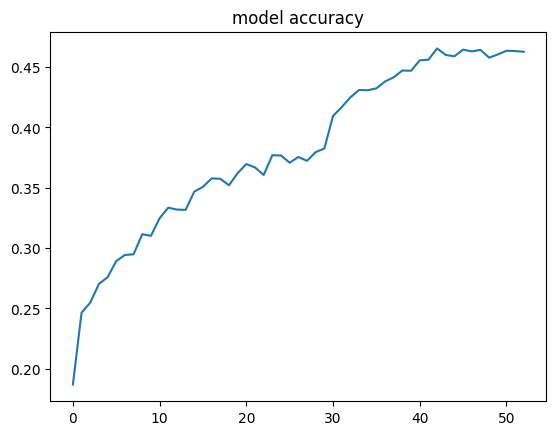

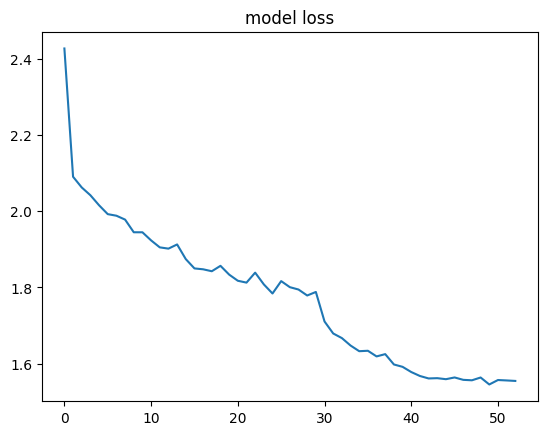

In [58]:
# Función auxiliar para graficar accuracy y loss
plt.plot(history.history['accuracy'])
plt.title('model accuracy')

plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.show()

In [59]:
# Validación en el conjunto de prueba
eval = model.evaluate(test_ds)
print(eval)

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.4002 - loss: 1.8204
[1.8260865211486816, 0.39989811182022095]


Repetimos para lr=1e-4

In [60]:
# Crear un nuevo modelo sin pesos previos
model_1e_4 = Model(inputs=img_inputs, outputs=outputs, name="ANN_model_1e_4")

# Compilación del modelo
model_1e_4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",#sparse_categorical_crossentropy
    metrics=['accuracy']
)

# Definir callbacks: EarlyStopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Entrenamiento del modelo
history_1e_4 = model_1e_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)

# Validación en el conjunto de prueba
eval_1e_4 = model_1e_4.evaluate(test_ds)
print(eval_1e_4)

model_1e_4.save('ANN_lr_1e-4.keras')

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4550 - loss: 1.5799 - val_accuracy: 0.4327 - val_loss: 1.7518 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4514 - loss: 1.5820 - val_accuracy: 0.4332 - val_loss: 1.7603 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4613 - loss: 1.5550 - val_accuracy: 0.4302 - val_loss: 1.7631 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4555 - loss: 1.5793 - val_accuracy: 0.4358 - val_loss: 1.7572 - learning_rate: 1.0000e-04
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4540 - loss: 1.5801 - val_accuracy: 0.4266 - val_loss: 1.7593 - learning_rate: 1.0000e-04
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4670 - loss: 1.5578 - val_accuracy: 0.4281 - val_loss: 1.7606 - learning_rate: 1.0000e-04
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/st

Finalizamos con lr=1e-5

In [61]:
# Crear un nuevo modelo sin pesos previos
model_1e_5 = Model(inputs=img_inputs, outputs=outputs, name="ANN_model_1e_5")

# Compilación del modelo
model_1e_5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Definir callbacks: EarlyStopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Entrenamiento del modelo
history_1e_5 = model_1e_5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)

# Validación en el conjunto de prueba
eval_1e_5 = model_1e_5.evaluate(test_ds)
print(eval_1e_5)

model_1e_5.save('ANN_lr_1e-5.keras')

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.4498 - loss: 1.5909 - val_accuracy: 0.4353 - val_loss: 1.7507 - learning_rate: 1.0000e-05
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4498 - loss: 1.5865 - val_accuracy: 0.4343 - val_loss: 1.7521 - learning_rate: 1.0000e-05
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.4549 - loss: 1.5722 - val_accuracy: 0.4317 - val_loss: 1.7541 - learning_rate: 1.0000e-05
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4498 - loss: 1.5821 - val_accuracy: 0.4322 - val_loss: 1.7552 - learning_rate: 1.0000e-05
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4619 - loss: 1.5716 - val_accuracy: 0.4332 - val_loss: 1.7542 - learning_rate: 1.0000e-05
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4545 - loss: 1.5749 - val_accuracy: 0.4332 - val_loss: 1.7555 - learning_rate: 1.0000e-05
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/st

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
    <ul>
        <li><strong>Forma de las curvas de entrenamiento</strong>: <br>La curva del model accuracy muestra un crecimiento rápido que empieza a decelerar alrededor del epoch 20 y vuelve a decelerar cerca del epoch 65. A partir de ahí parece estabilizarse
La curva del model loss tiene prácticamente la misma forma pero invertida. Decrece rápidamente los primeros 5 epochs, a partir de ese punto, decrece más suavemente manteniendo una pendiente bastante constante.</br>
</li>
        <li><strong>Número de epochs/tiempo de entrenamiento</strong>: <br>53 epochs / 10min 38seg<br>
11 epochs/ 1min 34seg<br>
11 epochs/ 1min 40seg</br>
        </li>        
        <li><strong>Desempeño del modelo en el conjunto de prueba</strong>: <br>lr=1e-3</br>
accuracy: 0.4002 - loss: 1.8204
<br>lr=1e-4</br>
accuracy: 0.3933 - loss: 1.8170
<br>lr=1e-5</br>
accuracy: 0.4060 - loss: 1.8156
        </li>
        <li><strong>Elección final</strong>: <br>El mejor resultado se obtiene con lr=1e-5, aunque todavía hay mucho margen de mejora.</br></li>
    </ul>
</div>

## 3. Red convolucional pequeña (2 puntos)

Ahora implementaremos una red neuronal convolucional (CNN) básica, que suele ser mucho más efectiva para clasificación de imágenes. Las CNN aprovechan la estructura espacial de los datos mediante capas concretas que permiten extraer características locales antes de la clasificación.

**Arquitectura propuesta**: Usaremos un modelo Keras Sequential para esta CNN. Constará de un bloque extractor de características y luego un clasificador denso similar al anterior pero más pequeño.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de Keras.

Se proporciona el código del clasificador ya implementado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 3.1 [0.5 pts]:</strong> Analiza el siguiente código y describe las capas que forman el bloque extractor de características y el clasificador.</div>

In [62]:
# Definición del modelo CNN
cnn_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name="CNN_model")
cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20, 20, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20, 20, 10)          │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,394 (110.91 KB)

 Trainable params: 28,394 (110.91 KB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br>
 <ul>
     <li><u>Bloque convolucional:</u> 
         <br>
    Rescaling(1./255),<br>
    Conv2D(16, 3, padding='same', activation='relu'),<br>
    MaxPooling2D(),<br>
    Conv2D(32, 3, padding='same', activation='relu'),<br>
    MaxPooling2D(),<br>
    Conv2D(64, 3, padding='same', activation='relu'),<br>
    MaxPooling2D(),<br>
    Dropout(0.2),<br>
         </br>
     </li>
     <li><u>Clasificador final:</u> 
     <br>
    Dense(64, activation='relu'),<br>
    Dropout(0.5),<br>
    Dense(10, activation='softmax')    
     </br>
     </li>
 </ul>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 3.2 [0.5 pts]:</strong> Compila el modelo con el optimizador <strong>Adam</strong> y <it>learning rate</it> = 1e-4. Entrena el modelo durante <strong>100 épocas</strong>, utilizando:
    <ul>
        <li><em>EarlyStopping</em> monitorizando la pérdida (<em>loss</em>) en validación, con paciencia de 10 épocas, restaurando los mejores pesos obtenidos.</li>
        <li><em>ReduceLROnPlateau</em> monitorizando la pérdida (<em>loss</em>) en validación, factor 0.2, paciencia de 5 épocas y un learning rate mínimo de 1e-6</i>
        <li>La métrica de desempeño <em>accuracy</em> tanto en entrenamiento como validación.</li>
    </ul>

Muestra una gráfica de las curvas de *accuracy* y *loss* para los conjuntos de entrenamiento y validación.

Finalmente, evalúa el modelo entrenado sobre el conjunto de <test>test</test>, mostrando la pérdida y exactitud (<it>accuracy</it>) final obtenidas en dichos datos.

<strong>Nota: durante la ejecución del código se producirá un error.</strong>

Explica a que és debido el error en la ejecución anterior y modifica el modelo para subsanarlo.

<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

In [63]:
# Compilar modelo CNN
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [64]:
# Definir callbacks EarlyStopping y ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [65]:
# Entrenamiento del modelo CNN
#history_cnn = cnn_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=100,
#    callbacks=[early_stopping,reduce_lr]
#)


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br>
<br>
 El error se debe a que a la primera capa Dense le están llegando 3 dimensiones, y debe de ser solo 1. Por lo que es necesario añadir una capa Flatten.
<br><br>
</div>

In [66]:
# Escribe aquí el modelo corregido
cnn_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name="CNN_model")
cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,698 (6.34 MB)

 Trainable params: 1,662,698 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 3.3 [0.5 pt]:</strong> Vuelve a repetir el ejercicio anterior (entrenamiento, mostrar gráficas y validación en test) con el modelo corregido. Comenta el tamaño del modelo, el número de epochs/tiempo de entrenamiento, las curvas de  entrenamiento y los resultados de validación.
<br><br>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>

</div>

In [67]:
# Compilar modelo CNN
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [68]:
# Definir callbacks EarlyStopping y ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [69]:
# Entrenamiento del modelo CNN
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)

cnn_model.save('cnn_model.keras')

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1737 - loss: 2.2423 - val_accuracy: 0.3532 - val_loss: 1.9765 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.2992 - loss: 1.9996 - val_accuracy: 0.4521 - val_loss: 1.7751 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3592 - loss: 1.8417 - val_accuracy: 0.4694 - val_loss: 1.6536 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3939 - loss: 1.7565 - val_accuracy: 0.5183 - val_loss: 1.5327 - learning_rate: 1.0000e-04
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4400 - loss: 1.6649 - val_accuracy: 0.5301 - val_loss: 1.4888 - learning_rate: 1.0000e-04
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4626 - loss: 1.5955 - val_accuracy: 0.5459 - val_loss: 1.4478 - learning_rate: 1.0000e-04
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/st

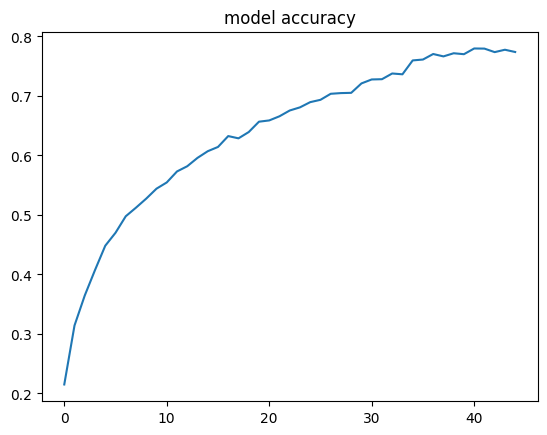

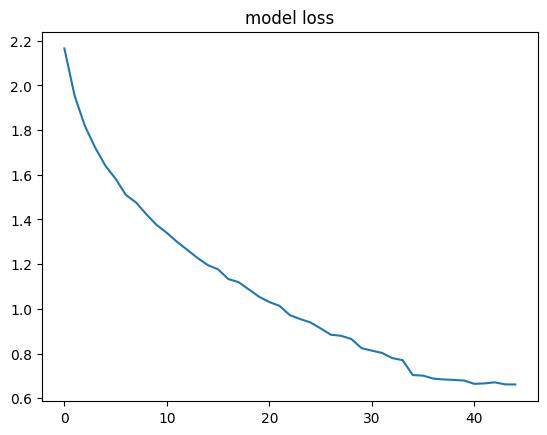

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6412 - loss: 1.1218
[1.0984277725219727, 0.6505348682403564]


In [70]:
# Resultados
plt.plot(history_cnn.history['accuracy'])
plt.title('model accuracy')

plt.show()
plt.plot(history_cnn.history['loss'])
plt.title('model loss')
plt.show()

eval_cnn = cnn_model.evaluate(test_ds)
print(eval_cnn)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
 En este caso ha utilizado 45 epochs en un tiempo de 5min 26seg. Obteniendo accuracy: 0.6412 - loss: 1.1218.
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 3.4 [0.5 pt]:</strong> Realiza una comparativa entre los modelos de los ejercicios 2 (con el learning rate escogido) y 3 en términos de:
<ul>
    <li><strong>Tamaño del modelo</strong></li>
    <li><strong>Evolución del entrenamiento</strong></li>
    <li><strong>Validación en el conjunto de test</strong></li>
    <li><strong>Tiempo de ejecución</strong></li>
</ul>

<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>

</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<ul>
    <li><strong>Tamaño del modelo</strong>:
    <br>Modelo ANN: 8.401.903 parámetros (32.05 MB) con 9 capas (incluyendo input)
    <br>Modelo CNN: 1,662,698 parámetros (6.34 MB) con 13 capas (incluyendo input)
    </li>
    <li><strong>Evolución del entrenamiento</strong>: Los dos modelos tienen una gráfica con forma muy parecida (el modelo cnn más suave) diferenciándose en el número de epochs (CNN 45 vs ANN 11.), la precisión y el nivel de perdida alcanzada.</li>
    <li><strong>Validación en el conjunto de test</strong>: El modelo CNN ha obtenido unos resultados de accuracy: 0.6412 (aumento del 53%) - loss: 1.1218 (disminución del 33%), mientras que el modelo de ANN de accuracy: 0.4060 - loss: 1.8156.</li>
    <li><strong>Tiempo de entrenamiento</strong>: Modelo CNN 5min 26seg y modelo ANN 1min 40seg.</li>
</ul>
</div>
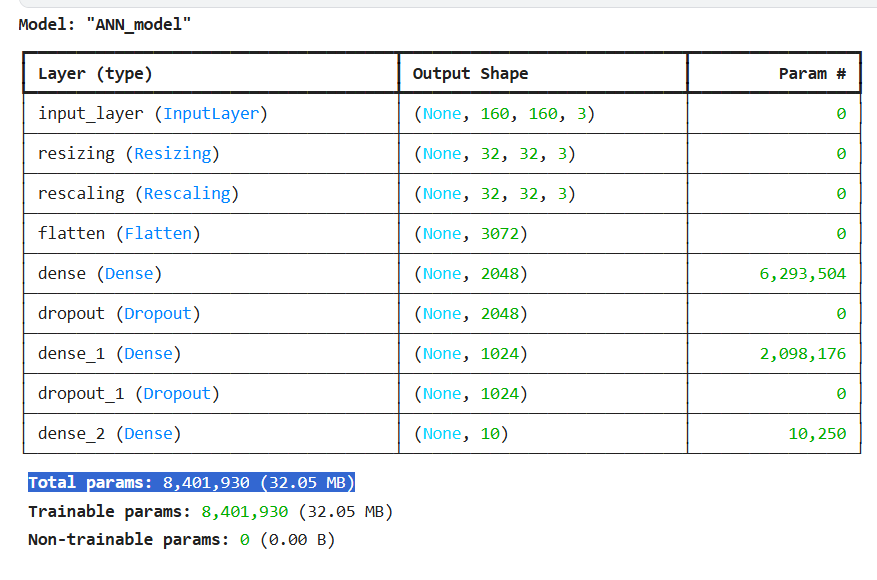

## 4. Aumentación de los datos (1 punto)

Aunque la CNN entrenada es bastante efectiva, podemos intentar mejorar su generalización aumentando artificialmente el tamaño y la diversidad del conjunto de entrenamiento mediante **técnicas de aumentación de datos**. La aumentación consiste en aplicar transformaciones aleatorias a las imágenes (giros, rotaciones, zoom, etc.) de modo que el modelo reciba variantes de las imágenes originales en cada época, simulando tener más datos

Keras proporciona capas de preprocesamiento de imagen que realizan estas transformaciones de forma eficiente durante el entrenamiento, por ejemplo RandomFlip, RandomRotation, RandomZoom entre otras.

Aquí utilizaremos algunas de estas capas para implementar la aumentación. En particular, probaremos con voltear horizontalmente las imágenes y aplicar pequeñas rotaciones aleatorias.

### 4.1. Definición y visualización de la aumentación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 4.1 [0.5 pts]:</strong> Crea un modelo <strong>Sequential</strong> de Keras que represente una capa de aumentación de datos con las siguientes capas:
    <ul>
        <li><code>RandomFlip</code> que voltee aleatoriamente las imágenes horizontalmente.</li>
        <li><code>RandomRotation</code> con factor de rotación de 0.1 (±10%).</li>
    </ul>
Selecciona una imagen del conjunto de entrenamiento y pásala a través de este modelo varias veces, mostrando las imágenes resultantes para comprobar visualmente las transformaciones realizadas (volteos y rotaciones). </div>

In [71]:
# Modelo de aumentación de datos
more_data_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomRotation(factor=0.1, seed=42)
], name="more_data_model")
more_data_model.summary()

Model: "more_data_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 160, 160, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

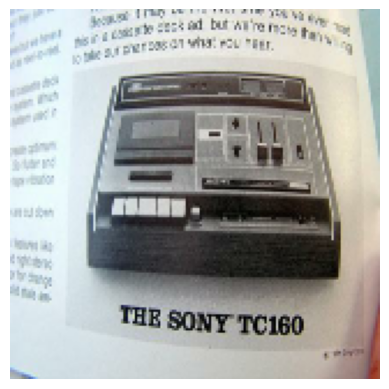

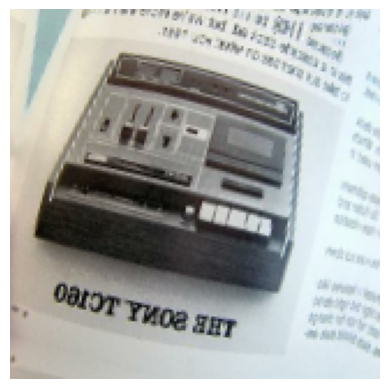

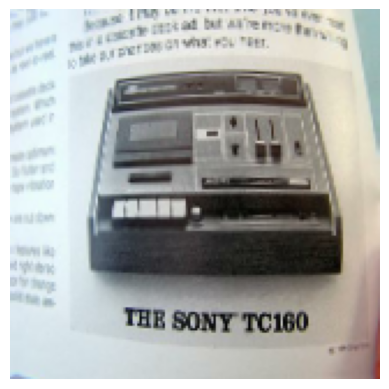

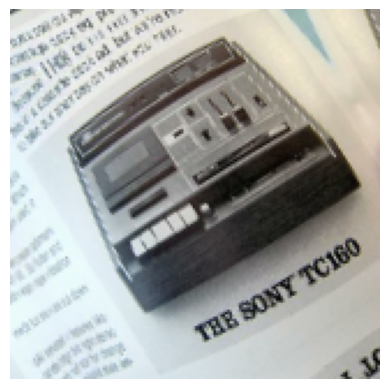

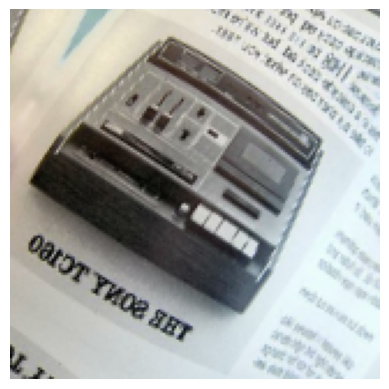

In [72]:
# Tomar un batch de entrenamiento y obtener una imagen

batch = train_ds.take(1).get_single_element()
images, labels = batch

plt.imshow(images[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()


# Aplicar aumentación varias veces y visualizar
image_v1 = more_data_model(images)
plt.imshow(image_v1[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

image_v2 = more_data_model(images)
plt.imshow(image_v2[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

image_v3 = more_data_model(images)
plt.imshow(image_v3[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

image_v4 = more_data_model(images)
plt.imshow(image_v4[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

# FUENTES:
# https://stackoverflow.com/questions/48126690/how-to-make-tf-data-dataset-return-all-of-the-elements-in-one-call
# https://www.tensorflow.org/tutorials/load_data/images?hl=es-419

### 4.2. Entrenamiento de la CNN con aumentación

Ahora incorporaremos la capa de aumentación al modelo CNN para entrenarlo con datos aumentados en cada época.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 4.2 [0.5 pts]:</strong> Inserta el modelo de aumentación de datos creado entre la capa de <code>Rescaling</code> y la primera <code>Conv2D</code> del modelo CNN anterior. Es decir, modifica la arquitectura para que las imágenes de entrada, tras ser reescaladas, pasen por las capas de <em>flip</em> y <em>rotation</em> aleatorias, y luego continúen por la CNN. A continuación, compila y entrena el nuevo modelo CNN aumentado siguiendo las mismas indicaciones que en el ejercicio anterior, <strong>excepto</strong> que esta vez usaremos un <strong>learning rate</strong> inicial mayor (1e-3). Mantén EarlyStopping, ReduceLROnPlateau, 100 épocas, etc. Luego evalúa el modelo final en el conjunto de test.

Comenta las diferencias con el modelo sin aumentación en términos de:

<ul>
    <li><strong>Evolución de las curvas de entrenamiento</strong></li>
    <li><strong>Validación en el conjunto de test</strong></li>
    <li><strong>Tiempo de entrenamiento</strong></li>
    <li><strong>Learning rate</strong></li>
</ul>

<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>

</div>

In [73]:
# Modelo CNN con aumentación de datos
cnn_more_data_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    more_data_model,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name="cnn_more_data_model")
cnn_more_data_model.summary()

Model: "cnn_more_data_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ more_data_model (Sequential)         │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,698 (6.34 MB)

 Trainable params: 1,662,698 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Compilación de la red
cnn_more_data_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [75]:
# Entrenamiento

# Definir callbacks EarlyStopping y ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-3
)

# Entrenamiento del modelo CNN
history_cnn = cnn_more_data_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)

cnn_more_data_model.save('cnn_more_data_model.keras')

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.1714 - loss: 2.2181 - val_accuracy: 0.4536 - val_loss: 1.7031 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.3647 - loss: 1.8366 - val_accuracy: 0.5336 - val_loss: 1.4344 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.4223 - loss: 1.6780 - val_accuracy: 0.5657 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4354 - loss: 1.6088 - val_accuracy: 0.5963 - val_loss: 1.2333 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4859 - loss: 1.5089 - val_accuracy: 0.5739 - val_loss: 1.2923 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.4892 - loss: 1.4876 - val_accuracy: 0.5923 - val_loss: 1.2300 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5216 - 

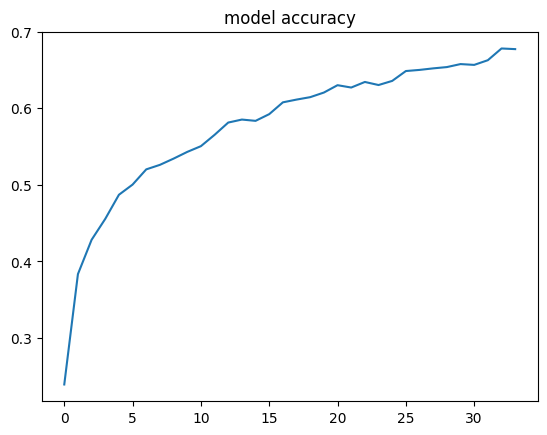

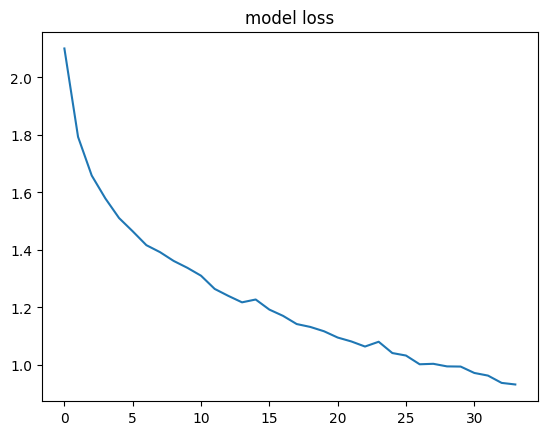

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6905 - loss: 0.9946
[0.9944239854812622, 0.6856851577758789]


In [76]:
# Resultados
plt.plot(history_cnn.history['accuracy'])
plt.title('model accuracy')

plt.show()
plt.plot(history_cnn.history['loss'])
plt.title('model loss')
plt.show()

eval_cnn = cnn_more_data_model.evaluate(test_ds)
print(eval_cnn)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>

<ul>
    <li><strong>Evolución de las curvas de entrenamiento</strong>: <br>La forma de las curvas es muy similar pero el modelo con data augmentation utiliza 36 épocas mientras que el modelo inicial ha empleado 46.
    </li>
    <li><strong>Validación en el conjunto de test</strong>: <br>Resultados data augmentation:
            <br>accuracy: 0.6905 - loss: 0.9946
        <br>Resultados modelo inicial:
            <br>accuracy: 0.6412 - loss: 1.1218</li>
    <li><strong>Tiempo de entrenamiento</strong>: <br>Con aumentación 4min 18seg</li>
    <li><strong>Learning rate</strong>: <br>Con aumentación 1e-3</li>
</ul>

</div>

In [77]:
# Definición de función de preprocesado de imágenes
def preprocess_image_for_sr(filepath):
    # Leemos imagen
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    # Conversión de las imágenes a float32 para normalizar entre 0 y 1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Definición de tamaño de imágenes hr(320x320) y lr(80x80)
    hr = tf.image.resize(img, [320, 320], method=tf.image.ResizeMethod.BICUBIC)
    lr = tf.image.resize(img, [80, 80], method=tf.image.ResizeMethod.BICUBIC)
    # Normalización de valores del tensor entre 0 y 1
    hr = tf.clip_by_value(hr, 0.0, 1.0)
    lr = tf.clip_by_value(lr, 0.0, 1.0)
    return lr, hr

# Creación de subconjuntos de entrenamiento y de validación
train_files = []
val_files = []
for cls in clases_train:
    cls_files = sorted((Path(train_path)/cls).glob("*.*"))
    # Para cada clase, separación del subconjunto de entrenamiento (80%) y validación (20%)
    split_idx = int(len(cls_files) * 0.2)
    val_files += [str(p) for p in cls_files[:split_idx]]
    train_files += [str(p) for p in cls_files[split_idx:]]
random.shuffle(train_files)
random.shuffle(val_files)

# Preparación de subconjuntos de entrenamiento y test para optimizar procesado
train_sr_ds = tf.data.Dataset.from_tensor_slices(train_files).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
val_sr_ds   = tf.data.Dataset.from_tensor_slices(val_files).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

## 5. Superresolución de imágenes con CNNs (2 pts)

Hasta ahora hemos trabajado en un problema de **clasificación**. En los apartados restantes abordaremos un problema distinto pero relacionado con la visión: la **superresolución de imágenes**. La superresolución consiste en generar una imagen de alta resolución (HR) a partir de una de baja resolución (LR), intentando recuperar o inferir los detalles perdidos al reducir la imagen. Es un problema de aprendizaje supervisado donde el modelo aprende una transformación imagen -> imagen.

Usaremos nuevamente la base de datos Imagenette para crear ejemplos de entrenamiento: a partir de cada imagen original (320px) generaremos una versión reducida (p. ej. 80px) que servirá como entrada, teniendo como salida esperada la imagen original. De este modo, el modelo aprenderá a mapear de baja a alta resolución. En lugar de una red convolucional para clasificación, necesitaremos una red capaz de procesar una imagen de entrada y producir una imagen de salida. Las **capas transpuestas de convolución** ([Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)) o técnicas de upsampling son las piezas clave para estos modelos, ya que permiten aumentar las dimensiones espaciales de los datos.

A continuación, crearemos el conjunto de datos para superresolución y entrenaremos una **CNN de superresolución simple**.

### 5.1. Preparación de datos LR/HR

Primero generaremos los pares de imágenes de entrenamiento y validación para superresolución. Partiremos de las imágenes originales de entrenamiento (y validación) a su resolución completa y, por simplicidad, las redimensionaremos a un tamaño fijo de 320×320 (ignorando la relación de aspecto original, similar a lo hecho en clasificación) para utilizarlas como imágenes de referencia de alta resolución (HR), y las reduciremos a 1/4 de su tamaño (aprox. 80×80) para usarlas como imágenes de entrada de baja resolución (LR). Para realizar ambas transformaciones (ajuste de las imágenes originales a 320x320 y su reducción a 80x80) utilizaremos métodos de [interpolación bicúbica](https://es.wikipedia.org/wiki/Interpolaci%C3%B3n_bic%C3%BAbica) para simular imágenes degradas suavemente.


Procedemos a obtener las rutas de imágenes de entrenamiento y validación, luego creamos un Dataset aplicando la función de mapeo que realiza la lectura y transformación:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 5.1.1 [0.5 pt]:</strong> El siguiente código prepara un nuevo conjunto de datos a partir de las imágenes de entrenamiento originales. Cada ejemplo consistirá en una imagen de baja resolución (LR) y su correspondiente imagen de alta resolución (HR). Concretamente, toma las imágenes de <code>/train/</code> (para crear los subconjuntos de entrenamiento y validación) a su tamaño completo (320px) como HR, y genera imágenes LR reduciéndolas a 1/4 de su tamaño lineal (∼80×80). Se pide:
<ul>
    <li>Completa los comentarios del código en aquellos sitios donde está marcado (#Poner comentario).</li>
</ul>
</div>

Procedemos a verificar la base de datos:

In [78]:
# Verificación de un par LR-HR
for lr_batch, hr_batch in train_sr_ds.take(1):
    lr_img = lr_batch[0].numpy()
    hr_img = hr_batch[0].numpy()
    print("LR shape:", lr_img.shape, "HR shape:", hr_img.shape)
    print("LR pixel range:", lr_img.min(), "-", lr_img.max())
    print("HR pixel range:", hr_img.min(), "-", hr_img.max())
    break


LR shape: (80, 80, 3) HR shape: (320, 320, 3)
LR pixel range: 0.0 - 1.0
HR pixel range: 0.0 - 1.0


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 5.1.2 [0.5 pt]:</strong> Contesta a las siguientes preguntas:
<ul>
    <li>¿A qué puede deberse el uso de la función 'clip_by_value' en el código anterior?</li>
    <li>¿Cómo se divide la base de datos? ¿Qué directorio se utiliza para su creación?¿Qué subconjuntos se crean? ¿Qué porcentaje de imágenes se asigna a cada conjunto? ¿Y en número de imágenes?</li>
    <li>Para cada elemento del conjunto de datos ¿qué formato tienen los datos que usaremos para entrenar el modelo? ¿y sus etiquetas?</li>
</ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
 <ul>
    <li><strong>Función 'clip_by_value'</strong>:  
        <br>Fuerza a los valores del tensor a estar entre 0 y 1. De esta forma quedan normalizados.</br>
    </li>
    <li><strong>Subconjuntos de la base de datos</strong>:  
        <br>Está dividida en las diferentes categorias de imágenes.
        <br>Se recorre el directorio de cada clase usando train_dir/nombre_de_la_clase y busca cualquier elemento que tenga un '.', es decir, que tenga una extensión.
        <br>Se crean los subconjuntos de entrenamiento (80% de las imágenes) y de validación (20% restante).
        <br>Entrenamiento 7575 y validación 1894.
 </br>
 </li>
    <li><strong>Formato de los datos y etiquetas</strong>:  
        <br>Imágenes jpeg, etiquetas vectores one-hote encoding</br>
    </li>
</ul>
</div>

### 5.2. Implementación del modelo de Superresolución

Ahora definimos un modelo CNN para superresolución. Optaremos por una arquitectura simple con [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) para escalar la imagen gradualmente. Implementamos el modelo:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 5.2 [1 pt]:</strong> Vamos a entrenar un modelo CNN para superresolución 4× (de 80px a 320px). Para ello:
    <ul>
        <li>Implementa un modelo de superresolución en Keras. Puedes usar el API funcional o Sequential. Sugerencia de arquitectura sencilla:
            <ul>
                <li>Entrada con shape (80,80,3).</li>
                <li>Varias capas Conv2D para extraer características en la resolución baja.</li>
                <li>Capa de <code>UpSampling2D</code> (factor=2) o <code>Conv2DTranspose</code> con <code>stride=2</code> para doblar el ancho y alto (80->160).</li>
                <li>Otra capa Conv2D para refinar, seguida de otra capa de upsampling 2× (160->320).</li>
                <li>Capas Conv2D finales para reconstruir la imagen de salida de 320×320×3. (Puedes usar activación lineal o ReLU para la salida; considera que buscamos valores de pixel entre 0-1 o 0-255).</li>
            </ul></li>
        <li>Compila el modelo con una función de pérdida apropiada para imágenes (por ejemplo, MSE) y sin métricas de accuracy. Entrénalo durante ~50-100 épocas, con EarlyStopping (paciencia 5-10, monitorizando val_loss) para asegurarte de no sobreentrenar.</li>
        <li>Comenta los resultados del entrenamiento. Concretamente:
            <ul>
                <li>Las curvas de entrenamiento.</li>
                <li>El tiempo de entrenamiento vs Tamaño del modelo.</li>
            </ul>                
        </li>
    </ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>
</div>

In [79]:
# Modelo de Super-Resolución (80px -> 320px)
super_resolution_model = keras.Sequential([
    # Entrada
    keras.layers.InputLayer(shape=(80, 80, 3)),
    # Capas Conv2D para extraer características en la resolución baja
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    # Capa Conv2DTranspose con stride=2 (80->160)
    UpSampling2D(size=(2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    # Capa Conv2D para refinar, seguida de otra capa de upsampling 2× (160->320)
    UpSampling2D(size=(2, 2)),
    # Capas Conv2D finales para reconstruir la imagen de salida de 320×320×3
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(3, 3, padding='same', activation='linear')
], name="super_resolution_model")
super_resolution_model.summary()

Model: "super_resolution_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 80, 80, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 160, 160, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 160, 160, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 320, 320, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 320, 320, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 320, 320, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,915 (167.64 KB)

 Trainable params: 42,915 (167.64 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Compilación de la red
super_resolution_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

In [81]:
# Entrenamiento de la red
# Definir callbacks EarlyStopping y ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5
)

# Entrenamiento del modelo CNN
history_cnn = super_resolution_model.fit(
    train_sr_ds,
    validation_data=val_sr_ds,
    epochs=50,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 112s 375ms/step - loss: 0.0339 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 259ms/step - loss: 0.0062 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - loss: 0.0060 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - loss: 0.0059 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 260ms/step - loss: 0.0059 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 260ms/step - loss: 0.0058 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 260ms/step - loss: 0.0058 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 260ms/step - loss: 0.0058 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 9/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 260ms/step - loss: 0.0058 - val_loss: 0.0057 - lear

In [86]:
super_resolution_model.save('super_resolution_model.keras')

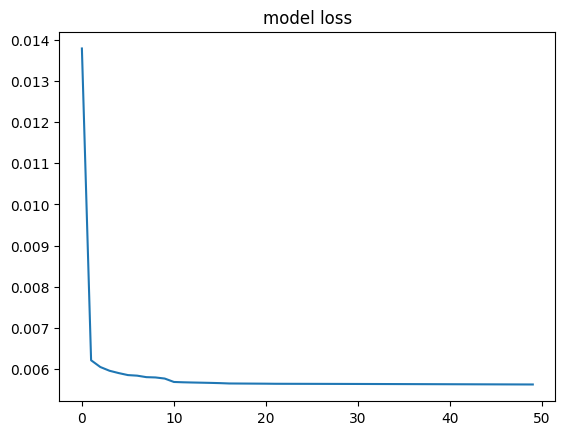

In [87]:
#super_resolution_model = keras.models.load_model('super_resolution_model.keras')

# Resultados
plt.plot(history_cnn.history['loss'])
plt.title('model loss')
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
<ul>
    <li><strong>Las curvas de entrenamiento</strong>: <br>En este caso no hay accuracy porque no estamos clasificando. La curva de loss muestra cómo desciende rápidamente la pérdida y entre los epochs 10 y 20 vemos como se estabiliza y baja muy lentamente.</br> </li>
    <li><strong>El tiempo de entrenamiento vs Tamaño del modelo</strong>: <br>Tiempo de entrenamiento: 1h 14min 46seg vs tamaño del modelo: 42,915 (167.64 KB)</li>
</ul>
</div>
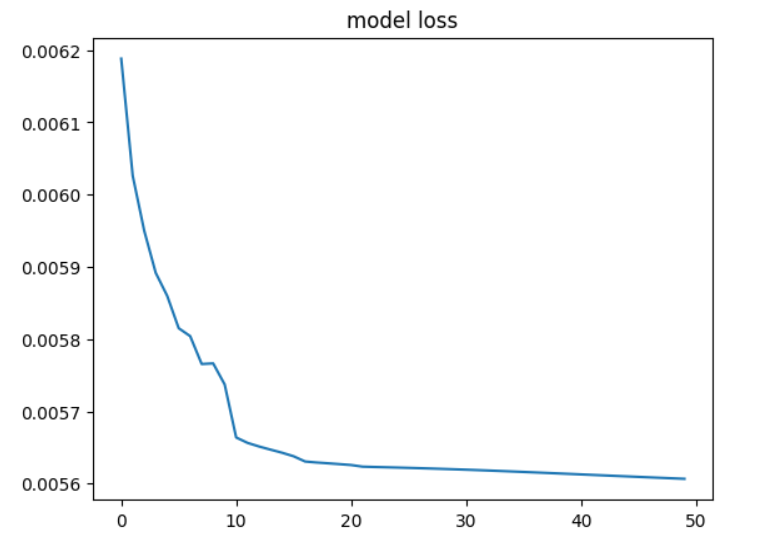

## 6. Inferencia, métricas y visualización de resultados (1 punto)

Con el modelo de superresolución entrenado, evaluaremos su desempeño tanto cuantitativamente (con métricas) como cualitativamente (visualizando imágenes). Para ello realizaremos la inferencia: esto es, tomar imágenes LR de test, pasarlas por el modelo sr_model para obtener imágenes superresueltas, y compararlas con las HR originales. Calcularemos la métrica [PSNR (Peak Signal-to-Noise Ratio)](https://es.wikipedia.org/wiki/PSNR) para cuantificar la calidad.

PSNR se mide en decibelios (dB) y valores más altos indican mayor similitud con la imagen original (por ejemplo, >30 dB suele indicar muy buena calidad de reconstrucción).

También visualizaremos algunos ejemplos, mostrando la imagen de baja resolución, la superresuelta por la CNN y la original de alta resolución, para inspeccionar los detalles a simple vista.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 6 [1 pt]:</strong> Realiza la inferencia del modelo de superresolución sobre varias imágenes de test:
    <ul>
        <li>Para cada imagen de test, obtén su versión de baja resolución (LR) y genera la imagen superresuelta (SR) con el modelo.</li>
        <li>Calcula la métrica PSNR comparando la imagen SR con la HR original para todo el conjunto de test (puedes usar <code>tf.image.psnr</code>) y obtén su valor medio.</li>
        <li>Muestra visualmente algunos ejemplos, incluyendo la imagen de entrada LR (puedes ampliarla para mostrarla del mismo tamaño utilizando el método <code>tf.image.resize()</code> junto con <code>method=tf.image.ResizeMethod.NEAREST_NEIGHBOR</code>), la imagen generada por el modelo (SR) y la imagen HR original, para poder comparar la calidad visualmente a parte del valor de la PSNR.</li>
    </ul>
Comenta los resultados obtenidos:
<ul>
    <li>¿Qué valores de PSNR se obtienen? (comentar tanto el de los ejemplos mostrados como el valor medio sobre el total del conjunto de test)</li>
    <li>¿Se ven nítidas las imágenes superresueltas?</li>
    <li>¿Qué tipos de detalles o errores se observan?</li>
</ul>
<strong> NOTA: Se valorará la concisión en la respuesta a las preguntas (una o dos frases son suficientes para cada una de las respuestas).</strong>  
</div>

In [88]:
# Preparar conjunto de test para SR (a partir de imagenette/val directory)
test_files = []
for cls in clases_val:
    cls_files = sorted((Path(train_path)/cls).glob("*.*"))
    test_files += [str(p) for p in cls_files]
random.shuffle(test_files)

# Preparación de conjunto de test para optimizar procesado (batch size = 1)
test_sr_ds   = tf.data.Dataset.from_tensor_slices(test_files).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE)

# Verificación de un par LR-HR
for lr_batch, hr_batch in test_sr_ds.take(1):
    lr_img = lr_batch[0].numpy()
    hr_img = hr_batch[0].numpy()
    print("LR shape:", lr_img.shape, "HR shape:", hr_img.shape)
    print("LR pixel range:", lr_img.min(), "-", lr_img.max())
    print("HR pixel range:", hr_img.min(), "-", hr_img.max())
    break


LR shape: (80, 80, 3) HR shape: (320, 320, 3)
LR pixel range: 0.029234346 - 1.0
HR pixel range: 0.0 - 1.0


In [89]:
# Lista para almacenar la PSNR de cada imagen
resultados_psnr = []

# Recorrer el dataset de test (batch size = 1)
for lr,hr in test_sr_ds:
    # Generar la imagen de superresolución a partir de la imagen LR
    sr_image = super_resolution_model(lr)
    
    # Quitar la dimensión de batch y asegurar que los valores estén en [0,1]
    sr_image = tf.squeeze(sr_image, axis=0)
    sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)
    
    # Convertir la imagen HR a array de numpy (quitamos la dimensión de batch)
    hr = np.array(hr)

    # Calcular la PSNR entre la imagen SR generada y la imagen HR original
    psnr = tf.image.psnr(hr, sr_image, max_val=1).numpy() #tensor->numpy

    # Almacenar el valor de PSNR en la lista
    resultados_psnr.append(psnr)    

# Calcular la PSNR media del conjunto de test
avg_psnr = np.mean(resultados_psnr)

print("PSNR media en el conjunto de test: {:.2f} dB".format(avg_psnr))

PSNR media en el conjunto de test: 24.02 dB


PSNR: 24.6079044342041


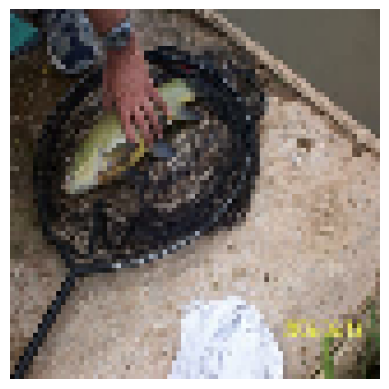

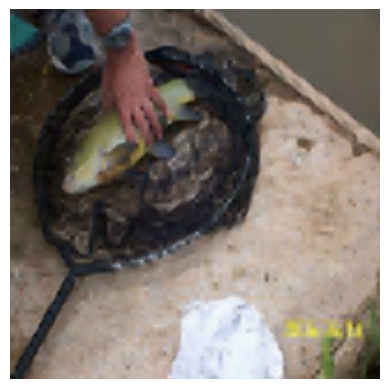

PSNR: 18.509166717529297


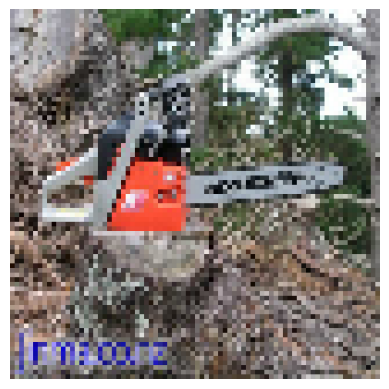

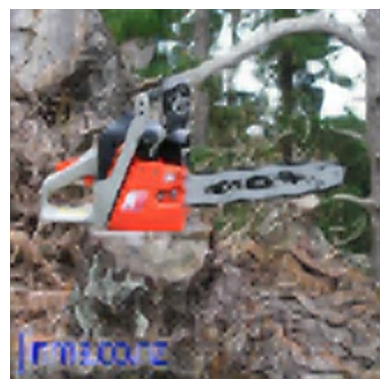

PSNR: 27.29688835144043


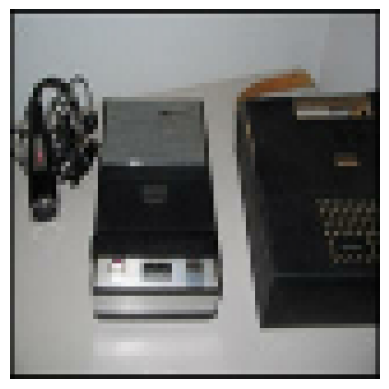

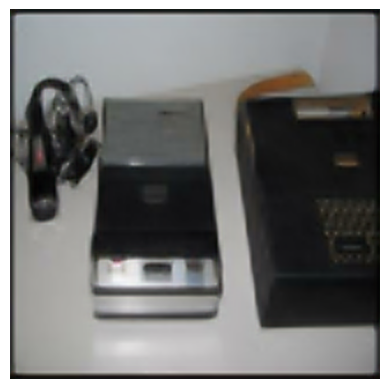

In [90]:
import math

# Elegir algunas imágenes de test aleatorias para visualización
sample_clases = random.sample(clases_val,3)

sample_img = []
for cls in sample_clases:
    cls_files = sorted((Path(val_path)/cls).glob("*.*"))
    sample_img.append(random.choice(cls_files))

# Para cada imagen
psnr = []
for img in sample_img:
    # Leer y procesar una imagen de test
    lr, hr = preprocess_image_for_sr(str(img))
    
    # Generar superresolución
    sr_image = super_resolution_model(tf.expand_dims(lr, axis=0))
    
    # Calcular PSNR
    sr_image = tf.squeeze(sr_image, axis=0)
    sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)
    hr = np.array(hr)
    psnr = tf.image.psnr(hr, sr_image, max_val=1).numpy()
    print(f"PSNR: {psnr}")
    
    # Preparar imágenes para visualizar del mismo tamaño
    lr_resized = tf.image.resize(lr, [320, 320], method='nearest')
    sr_resized = tf.image.resize(sr_image, [320, 320], method='nearest')
    
    # Las imágenes están en [0,1], escalar a [0,255] para mostrar correctamente
    lr_scaled = (lr_resized * 255).numpy().astype("uint8")
    sr_scaled = (sr_resized * 255).numpy().astype("uint8")

    # Mostrar las imágenes
    plt.imshow(lr_scaled)
    plt.axis('off')
    plt.show()
    plt.imshow(sr_scaled)
    plt.axis('off')
    plt.show()


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
   Análisis de resultados del modelo SR:
   <ul>
       <li><strong>PSNR</strong>:<br>PSNR media en el conjunto de test: 24.02 dB.<br>PNSR(1): 24.6079<br>PNSR(2): 18.5092<br>PNSR(3): 27.2969</br></li>
       <li><strong>Calidad visual</strong>:<br>Se aprecia una gran mejora en cuanto a la nitidez, aunque se podría mejorar añadiendo algunas capas CONV2D más al modelo y proporcionándole más entrenamiento.</br></li>
       <li><strong>Errores</strong>:<br>No están bien definidos los pequeños detalles.</br></li>
   </ul>

</div>

## 7. Modelo pre-entrenado en superresolución (1 punto)

Los avances recientes en superresolución han producido arquitecturas más complejas (p. ej., basadas en Redes Generativas Adversarias) que logran resultados notablemente mejores, a costa de un entrenamiento costoso. Uno de estos modelos es ESRGAN ([Enhanced Super-Resolution GAN por Xintao Wang et al.](https://arxiv.org/abs/1809.00219), entrenado en grandes bases de datos de imágenes HD (como DIV2K) para lograr superresolución 4× con gran fidelidad. Afortunadamente, podemos aprovechar un modelo pre-entrenado en lugar de entrenar uno desde cero.

Vamos a emplear un modelo pre-entrenado de ESRGAN disponible vía [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/image_enhancing)

Este modelo ha sido entrenado en el conjunto DIV2K (imágenes de alta calidad) con degradación bicúbica, por lo que está especializado en producir imágenes 4× más grandes con notable detalle.

Usaremos ESRGAN para aplicar superresolución a las mismas imágenes de test y compararemos los resultados con nuestro modelo implementado en el ejercicio 5.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 7 [1 pt]:</strong> Utiliza un modelo pre-entrenado de superresolución (p. ej. ESRGAN 4×) para mejorar las imágenes de baja resolución. En concreto:
    <ul>
        <li>Carga el modelo pre-entrenado desde TensorFlow Hub (usa la URL proporcionada, por ejemplo <code>"https://tfhub.dev/captain-pool/esrgan-tf2/1"</code>).</li>
        <li>Para una selección de imágenes de test de baja resolución (80×80), obtén la superresolución 4× con este modelo.</li>
        <li>Calcula la PSNR de las imágenes generadas por el modelo pre-entrenado (en el total del conjunto de test) y compara su media con la PSNR media obtenida por tu modelo.</li>
        <li>Visualiza las imágenes de salida del modelo pre-entrenado junto a las de tu modelo y las originales, para comparar visualmente la calidad. Compara también la PSNR de esas imágenes.</li>
    </ul>
Discute las diferencias observadas:
    <ul>
        <li>¿El modelo pre-entrenado obtiene mejores métricas?</li>
        <li>¿El modelo pre-entrenado produce imágenes más nítidas y cercanas a la realidad?</li>
        <li>¿En qué detalles se nota la mejoría?</li>
    </ul>    
</div>

In [91]:
import tensorflow_hub as hub
import kagglehub

# Download latest version
path = kagglehub.model_download("kaggle/esrgan-tf2/tensorFlow2/esrgan-tf2")

print("Path to model files:", path)

# Cargamos el modelo ESRGAN desde TF-Hub:
#esrgan = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
#print("Modelo ESRGAN cargado.")

Path to model files: /kaggle/input/esrgan-tf2/tensorflow2/esrgan-tf2/1


In [92]:
esrgan = hub.load('/kaggle/input/esrgan-tf2/tensorflow2/esrgan-tf2/1')

In [122]:
from tqdm import tqdm

# Lista para almacenar la PSNR de cada imagen usando ESRGAN
resultados_psnr_esrgan = []

# Recorrer el dataset de test (batch size = 1)

total_steps = sum(1 for _ in test_sr_ds)  # Total de iteraciones conocidas
for lr, hr in tqdm(test_sr_ds, total=total_steps, desc="Procesando imágenes"):

    # Preparar la imagen LR para ESRGAN:
    # ESRGAN espera entrada en rango [0,255] como float32, y test_sr_ds tiene imágenes en [0,1]
    lr_scaled = (lr * 255).numpy().astype("float32")
    
    # Generar la imagen de superresolución con ESRGAN
    sr_image = esrgan(lr_scaled)

    # Quitar la dimensión de batch y normalizar la salida a [0,1]
    sr_image = tf.squeeze(sr_image, axis=0)
    sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)

    # Obtener la imagen HR correspondiente (quitamos la dimensión de batch)
    hr = np.array(hr)
    
    # Calcular la PSNR entre la imagen generada por ESRGAN y la imagen HR original
    psnr = tf.image.psnr(hr, sr_image, max_val=1).numpy()
    resultados_psnr_esrgan.append(psnr)


# Calcular la PSNR media en el conjunto de test con ESRGAN
avg_psnr_esrgan = np.mean(resultados_psnr_esrgan)
print("PSNR media en el conjunto de test con ESRGAN: {:.2f} dB".format(avg_psnr_esrgan))

# FUENTE:
# https://www.datacamp.com/tutorial/tqdm-python

Procesando imágenes: 100%|██████████| 9469/9469 [04:27<00:00, 35.35it/s]

PSNR media en el conjunto de test con ESRGAN: 5.06 dB


PSNR: 12.894539833068848


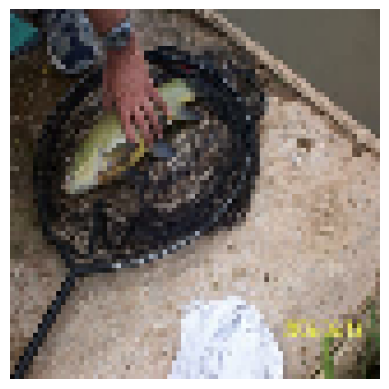

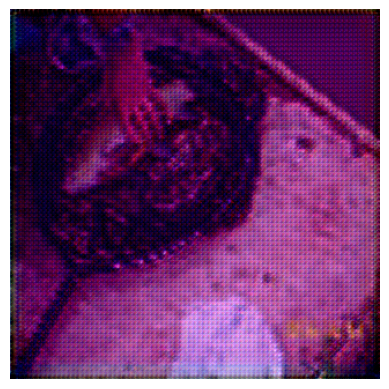

PSNR: 10.997822761535645


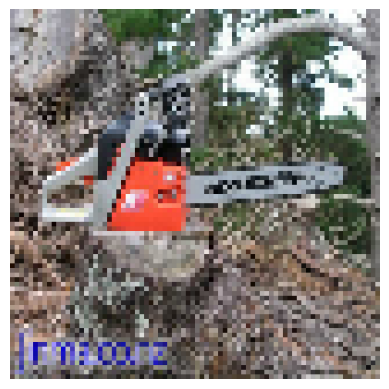

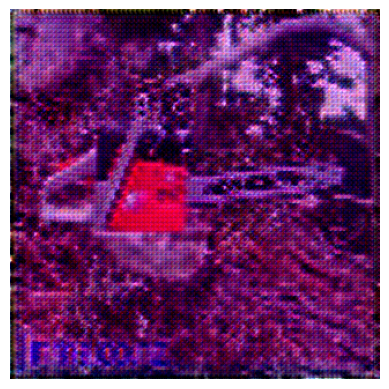

PSNR: 12.845222473144531


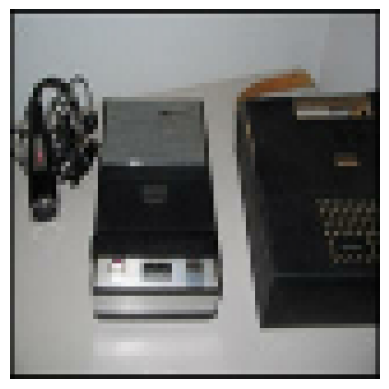

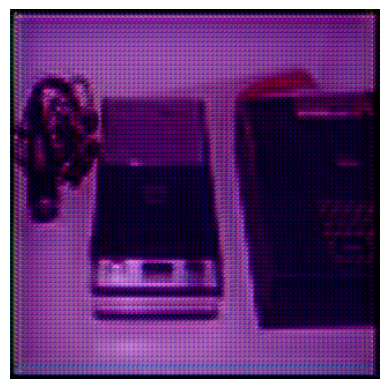

In [121]:
# Aplicamos ESRGAN a las mismas imágenes de ejemplo que usamos con nuestro modelo

# Para cada imagen

    # Preparar la imagen LR de test

    # Convertir salida a [0,1] float

    # Calcular PSNR comparado con HR

    # Visualizar comparativa

# Para cada imagen
psnr = []
for img in sample_img:
    # Leer y procesar una imagen de test
    lr, hr = preprocess_image_for_sr(str(img))
    
    # Generar superresolución
    sr_image = esrgan(tf.expand_dims(lr, axis=0))
    
    # Calcular PSNR
    sr_image = tf.squeeze(sr_image, axis=0)
    sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)
    hr = np.array(hr)
    psnr = tf.image.psnr(hr, sr_image, max_val=1).numpy()
    print(f"PSNR: {psnr}")
    
    # Preparar imágenes para visualizar del mismo tamaño
    lr_resized = tf.image.resize(lr, [320, 320], method='nearest')
    sr_resized = tf.image.resize(sr_image, [320, 320], method='nearest')
    
    # Las imágenes están en [0,1], escalar a [0,255] para mostrar correctamente
    lr_scaled = (lr_resized * 255).numpy().astype("uint8")
    sr_scaled = (sr_resized * 255).numpy().astype("uint8")

    # Mostrar las imágenes
    plt.imshow(lr_scaled)
    plt.axis('off')
    plt.show()
    plt.imshow(sr_scaled)
    plt.axis('off')
    plt.show()


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<ul>
    <li><strong>Métricas (PSNR)</strong>:  En este caso, a pesar de ser un mejor modelo y más entrenado, estamos obteniendo un PSNR muy bajo (5.06db). Lo que indica que probablemente se haya cometido un error en el código.</li>
    <li><strong>Calidad visual</strong>:  Debido al bajo PSNR, las imágenes no muestran mejora tras pasar por el modelo. </li>
    <li><strong>Detalles</strong>:  En este caso no hemos podido obtener mejoría.</li>
</ul>  
</div>

## 8. Comparativa y conclusiones (0.5 pts)

En esta práctica hemos explorado tanto la clasificación de imágenes con redes neuronales (densas vs convolucionales) como la superresolución con CNNs, aplicándolo todo sobre la base de datos Imagenette.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Ejercicio 8[0.5 pts]:</strong> Realiza un resumen de los puntos aprendidos en esta PEC. En concreto, resume en una frase lo aprendido sobre cada uno de los puntos que se enumeran a continuación: <ul>
    <li><strong>ANN vs CNN:</strong></li>
    <li><strong>Regularización y aumentación:</strong></li>
    <li><strong>Superresolución:</strong></li>
    <li><strong>Transfer learning:</strong></li>
</ul></div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Conclusiones finales:
<ul>
    <li>
        <strong>ANN vs CNN:</strong>  Las CNN, aunque más lentas de entrenar, son mucho más efectivas para clasificar imágenes.
    </li>
    <li>
        <strong>Regularización y aumentación:</strong>   Permiten entrenar de forma más efectiva a los modelos de clasificación aplicando operaciones sencillas previas.
    </li>
    <li>
        <strong>Superresolución:</strong>  A partir de un modelo construido y bien entrenado para este propósito se pueden conseguir grandes mejoras en la resolución de imágenes.
    </li>
    <li>
        <strong>Transfer learning:</strong>  Permite aprovechar el entrenamiento de un modelo y aplicarlo a un caso particular sin necesidad de volver a entrenarlo específicamente para ese caso.
    </li>
</ul>
<br><br>
</div>